In [1]:
import math
import scipy as sp
from scipy.stats import bernoulli, uniform, chi2
import numpy as np
from numpy.testing import assert_allclose
import json
from matplotlib import pyplot as plt
np.random.seed(123456789)

In [2]:
!pip install rilacs
from rilacs.strategies import linear_gamma_dist
import pytest
from rilacs.martingales import (
    apriori_Kelly_martingale,
    distKelly_martingale,
    sqKelly_martingale,
    dKelly_martingale,
)
import itertools

In [3]:
# to save dicts as json
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [4]:
def sprt_mart(x : np.array, N : int, mu : float=1/2, eta: float=1-np.finfo(float).eps, \
              u: float=1, random_order = True):
    '''
    Finds the p value for the hypothesis that the population 
    mean is less than or equal to mu against the alternative that it is eta,
    for a population of size N of values in the interval [0, u].
    
    Generalizes Wald's SPRT for the Bernoulli to sampling without replacement and to bounded
    values rather than binary values.

    If N is finite, assumes the sample is drawn without replacement
    If N is infinite, assumes the sample is with replacement
    
    Data are assumed to be in random order. If not, the calculation for sampling without replacement is incorrect.


    
    Parameters:
    -----------
    x : binary list, one element per draw. A list element is 1 if the 
        the corresponding trial was a success
    N : int
        population size for sampling without replacement, or np.infinity for 
        sampling with replacement
    theta : float in (0,u)
        hypothesized population mean
    eta : float in (0,u)
        alternative hypothesized population mean
    random_order : Boolean
        if the data are in random order, setting this to True can improve the power.
        If the data are not in random order, set to False
    '''
    if any((xx < 0 or xx > u) for xx in x):
        raise ValueError(f'Data out of range [0,{u}]')
    if np.isfinite(N):
        if not random_order:
            raise ValueError("data must be in random order for samples without replacement")
        S = np.insert(np.cumsum(x),0,0)[0:-1]  # 0, x_1, x_1+x_2, ...,  
        j = np.arange(1,len(x)+1)              # 1, 2, 3, ..., len(x)
        m = (N*mu-S)/(N-j+1)                   # mean of population after (j-1)st draw, if null is true
    else:
        m = mu
    with np.errstate(divide='ignore',invalid='ignore'): 
        terms = np.cumprod((x*eta/m + (u-x)*(u-eta)/(u-m))/u) # generalization of Bernoulli SPRT
    terms[m<0] = np.inf                        # the null is surely false
    return terms


In [5]:
def shrink_trunc(x: np.array, N: int, mu: float=1/2, nu: float=1-np.finfo(float).eps, u: float=1, c: float=1/2, 
                 d: float=100) -> np.array: 
    '''
    apply the shrinkage and truncation estimator to an array
    
    sample mean is shrunk towards nu, with relative weight d times the weight of a single observation.
    estimate is truncated above at u-u*eps and below at mu_j+e_j(c,j)
    
    S_1 = 0
    S_j = \sum_{i=1}^{j-1} x_i, j > 1
    m_j = (N*mu-S_j)/(N-j+1) if np.isfinite(N) else mu
    e_j = c/sqrt(d+j-1)
    eta_j =  ( (d*nu + S_j)/(d+j-1) \vee (m_j+e_j) ) \wedge u*(1-eps)
    
    Parameters
    ----------
    x : np.array
        input data       
    mu : float in (0, 1)
        hypothesized population mean
    eta : float in (t, 1)
        initial alternative hypothethesized value for the population mean
    c : positive float
        scale factor for allowing the estimated mean to approach t from above
    d : positive float
        relative weight of nu compared to an observation, in updating the alternative for each term
    '''
    S = np.insert(np.cumsum(x),0,0)[0:-1]  # 0, x_1, x_1+x_2, ...,  
    j = np.arange(1,len(x)+1)              # 1, 2, 3, ..., len(x)
    m = (N*mu-S)/(N-j+1) if np.isfinite(N) else mu   # mean of population after (j-1)st draw, if null is true 
    return np.minimum(u*(1-np.finfo(float).eps), np.maximum((d*nu+S)/(d+j-1),m+c/np.sqrt(d+j-1)))

In [6]:
def alpha_mart(x: np.array, N: int, mu: float=1/2, eta: float=1-np.finfo(float).eps, u: float=1, \
               estim: callable=shrink_trunc) -> np.array :
    '''
    Finds the ALPHA martingale for the hypothesis that the population 
    mean is less than or equal to t using a martingale method,
    for a population of size N, based on a series of draws x.
    
    The draws must be in random order, or the sequence is not a martingale under the null
    
    If N is finite, assumes the sample is drawn without replacement
    If N is infinite, assumes the sample is with replacement

    Parameters
    ----------
    x : list corresponding to the data
    N : int
        population size for sampling without replacement, or np.infinity for sampling with replacement
    mu : float in (0,1)
        hypothesized fraction of ones in the population
    eta : float in (t,1) 
        alternative hypothesized population mean
    estim : callable
        estim(x, N, mu, eta, u) -> np.array of length len(x), the sequence of values of eta_j for ALPHA
               
    Returns
    -------   
    terms : array
        sequence of terms that would be a nonnegative supermartingale under the null
    '''
    S = np.insert(np.cumsum(x),0,0)[0:-1]  # 0, x_1, x_1+x_2, ...,  
    j = np.arange(1,len(x)+1)              # 1, 2, 3, ..., len(x)
    m = (N*mu-S)/(N-j+1) if np.isfinite(N) else mu   # mean of population after (j-1)st draw, if null is true 
    etaj = estim(x, N, mu, eta, u) 
    with np.errstate(divide='ignore',invalid='ignore'):
        terms = np.cumprod((x*etaj/m + (u-x)*(u-etaj)/(u-m))/u)
    terms[m<0] = np.inf
    return terms

In [7]:
def overstatement(x: float=None, eta: float=None, u: float=1):
    return (1-(eta-x)/u)/(2-(2*eta-1)/u)

def upper_bound(eta: float, u: float=1):
    return 2/(2-(2*eta-1)/u)

def assorter_mean(eta: float, u: float=1):
    return u/(1-2*eta+2*u)

## Dependence of upper and lower bounds on the assorter margin

In [8]:
def overstatement(v: float, x: float)-> float:
    return (1-v+2*x)/(2*(2-v))

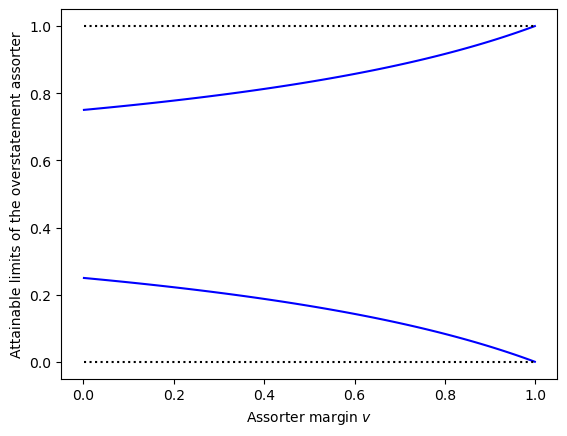

In [9]:
vs = np.linspace(0.001, .999, 100)
lbs = np.array([overstatement(v, 0) for v in vs])
ubs = np.array([overstatement(v, 1) for v in vs])
upp = np.ones(len(ubs))
low = np.zeros(len(ubs))
plt.plot(vs, lbs, color="blue")
plt.plot(vs, ubs, color="blue")
plt.plot(vs, upp, linestyle="dotted", color="black")
plt.plot(vs, low, linestyle="dotted", color="black")
plt.ylabel('Attainable limits of the overstatement assorter')
plt.xlabel('Assorter margin $v$')
# plt.show()
plt.savefig('../bounds.png', bbox_inches='tight')

## Sampling without replacement with some non-votes

In [10]:
# Tables 3 and 4

reps = int(10**3)

thetal = [.505, .51, .52, .55, .6]
blanks = [.1, .25, .5, .75]
Nl = [10000, 100000, 500000]
etal = thetal  
alpha = 0.05

# for ALPHA
c_base=0.5
dl= [10, 100, 1000]

# for RiLACs
D = 10
beta = 1

# for ONEAudit
one_frac = 0.99  # fraction of the upper bound to use for null mean

resl = ['rej_N','not_rej_N']

results_a_b = {}
results_apa_b = {}
results_apk_b = {}
results_sqk_b = {}
results_comp_b = {}
results_comp_a_b = {}

for theta in thetal:
    print(f'{theta=}')
    results_a_b[theta] = {}
    results_apa_b[theta] = {}
    results_apk_b[theta] = {}
    results_sqk_b[theta] = {}
    results_comp_b[theta] = {}
    results_comp_a_b[theta] = {}
    for N in Nl:
        print(f'\t{N=}')
        results_a_b[theta][N] = {}
        results_apa_b[theta][N] = {}
        results_apk_b[theta][N] = {}
        results_sqk_b[theta][N] = {}
        results_comp_b[theta][N] = {}
        results_comp_a_b[theta][N] = {}
        for b in blanks:
            print(f'\t\tblanks={b}')
            results_a_b[theta][N][b] = {}
            results_apa_b[theta][N][b] = {}
            results_apk_b[theta][N][b] = {}
            results_sqk_b[theta][N][b] = {}
            results_comp_b[theta][N][b] = {}
            results_comp_a_b[theta][N][b] = {}
            non_blank = int(N*(1-b))
            n_A = int(non_blank*theta)
            n_B = non_blank - n_A
            x = np.array([1]*n_A+[0]*n_B+[0.5]*(N-non_blank))
            for r in resl:
                results_sqk_b[theta][N][b][r] = 0
            for eta in etal:
                results_apk_b[theta][N][b][eta] = {}
                results_apa_b[theta][N][b][eta] = {}
                results_comp_b[theta][N][b][eta] = {}
                for r in resl:
                    results_apk_b[theta][N][b][eta][r] = 0
                    results_apa_b[theta][N][b][eta][r] = 0
                    results_comp_b[theta][N][b][eta][r] = 0
                results_a_b[theta][N][b][eta]={} 
                results_comp_a_b[theta][N][b][eta]={} 
                for d in dl:
                    results_a_b[theta][N][b][eta][d] = {}
                    results_comp_a_b[theta][N][b][eta][d]={} 
                    for r in resl:
                        results_a_b[theta][N][b][eta][d][r] = 0
                        results_comp_a_b[theta][N][b][eta][d][r]= 0
            for i in range(reps):
                np.random.shuffle(x)

                # sqKelly
                mart = sqKelly_martingale(x, m=1/2, N=N, D=D, beta=beta)
                # rejections by N
                found = np.argmax(mart >= 1/alpha)
                results_sqk_b[theta][N][b]['rej_N'] += found
                results_sqk_b[theta][N][b]['not_rej_N'] += (found==0) # should not occur   

                # a priori Kelly and a priori SPRT
                for eta in etal:
                    n_eta_A = int(non_blank*eta)
                    n_eta_B = non_blank - n_eta_A
                    eta_shangrla = (non_blank*eta + (N-non_blank)/2)/N
                    eta_oneaudit = assorter_mean(eta_shangrla)
                    c = c_base*(eta-1/2)

                    # a priori Kelly
                    mart = apriori_Kelly_martingale(x, m=0.5, N=N, n_A=n_eta_A, n_B=n_eta_B)
                    # rejections by N
                    found = np.argmax(mart >= 1/alpha)
                    results_apk_b[theta][N][b][eta]['rej_N'] += found
                    results_apk_b[theta][N][b][eta]['not_rej_N'] += (found==0) # should not occur

                    # a priori SPRT
                    mart = sprt_mart(x, N, mu=1/2, eta=eta_shangrla, u=1, random_order=True)
                    # rejections by N
                    found = np.argmax(mart >= 1/alpha)
                    results_apa_b[theta][N][b][eta]['rej_N'] += found
                    results_apa_b[theta][N][b][eta]['not_rej_N'] += (found==0) # should not occur        

                    # ALPHA
                    for d in dl:               
                        mart = alpha_mart(x, N, mu=1/2, eta=eta_shangrla, u=1, \
                                          estim=lambda x, N, mu, eta, u: shrink_trunc(x,N,mu,eta,1,c=c,d=d))
                        # rejections by N
                        found = np.argmax(mart >= 1/alpha)
                        results_a_b[theta][N][b][eta][d]['rej_N'] += found
                        results_a_b[theta][N][b][eta][d]['not_rej_N'] += (found==0) # should not occur        

                    # OneAudit a priori
                    mart = sprt_mart(x, N, mu=1/2, eta=eta_oneaudit, u=upper_bound(eta), random_order=True)
                    # rejections by N
                    found = np.argmax(mart >= 1/alpha)
                    results_comp_b[theta][N][b][eta]['rej_N'] += found
                    results_comp_b[theta][N][b][eta]['not_rej_N'] += (found==0) # should not occur        
                    
                    # OneAudit ALPHA
                    for d in dl:               
                        mart = alpha_mart(x, N, mu=1/2, eta=eta_oneaudit, u=upper_bound(eta), \
                                          estim=lambda x, N, mu, eta, u: shrink_trunc(x,N,mu,eta,1,c=c,d=d))
                        # rejections by N
                        found = np.argmax(mart >= 1/alpha)
                        results_comp_a_b[theta][N][b][eta][d]['rej_N'] += found
                        results_comp_a_b[theta][N][b][eta][d]['not_rej_N'] += (found==0) # should not occur        

for theta in thetal:
    for N in Nl:
        for b in blanks:
            results_sqk_b[theta][N][b]['rej_N'] = results_sqk_b[theta][N][b]['rej_N']/ \
                                                  (reps-results_sqk_b[theta][N][b]['not_rej_N']) + 1
            if results_sqk_b[theta][N][b]['not_rej_N'] > 0:
                print(f'sqKelly did not reject for {theta=}, {N=}, {b=}')  # sanity check

            for eta in etal:
                results_apk_b[theta][N][b][eta]['rej_N'] = results_apk_b[theta][N][b][eta]['rej_N']/ \
                                                  (reps-results_apk_b[theta][N][b][eta]['not_rej_N']) + 1
                if results_apk_b[theta][N][b][eta]['not_rej_N'] > 0:
                    print(f'a priori Kelly did not reject for {theta=},{N=}, {b=}, {eta=}')

                results_comp_b[theta][N][b][eta]['rej_N'] = results_comp_b[theta][N][b][eta]['rej_N']/ \
                                                  (reps-results_comp_b[theta][N][b][eta]['not_rej_N']) + 1
                if results_comp_b[theta][N][b][eta]['not_rej_N'] > 0:
                    print(f'a 1Audit comp_b did not reject for {theta=},{N=}, {b=}, {eta=}')
                    
                results_apa_b[theta][N][b][eta]['rej_N'] = results_apa_b[theta][N][b][eta]['rej_N']/\
                                                  (reps-results_apa_b[theta][N][b][eta]['not_rej_N']) + 1
                if results_apa_b[theta][N][b][eta]['not_rej_N'] > 0:
                    print(f'a priori ALPHA did not reject for {theta=}, {N=}, {b=}, {eta=}')

                for d in dl:
                    results_a_b[theta][N][b][eta][d]['rej_N'] = results_a_b[theta][N][b][eta][d]['rej_N']/\
                                                  (reps-results_a_b[theta][N][b][eta][d]['not_rej_N']) + 1
                    results_comp_a_b[theta][N][b][eta][d]['rej_N'] = results_comp_a_b[theta][N][b][eta][d]['rej_N']/\
                                                  (reps-results_comp_a_b[theta][N][b][eta][d]['not_rej_N']) + 1
                    if results_a_b[theta][N][b][eta][d]['not_rej_N'] > 0:
                        print(f'ALPHA did not reject for {theta=}, {N=}, {b=}, {eta=}, {d=}')
                    if results_comp_a_b[theta][N][b][eta][d]['not_rej_N'] > 0:
                        print(f'1Audit comp_a_b did not reject for {theta=}, {N=}, {b=}, {eta=}, {d=}')

theta=0.505
	N=10000
		blanks=0.1
		blanks=0.25
		blanks=0.5
		blanks=0.75
	N=100000
		blanks=0.1
		blanks=0.25
		blanks=0.5
		blanks=0.75
	N=500000
		blanks=0.1
		blanks=0.25
		blanks=0.5
		blanks=0.75
theta=0.51
	N=10000
		blanks=0.1
		blanks=0.25
		blanks=0.5
		blanks=0.75
	N=100000
		blanks=0.1
		blanks=0.25
		blanks=0.5
		blanks=0.75
	N=500000
		blanks=0.1
		blanks=0.25
		blanks=0.5
		blanks=0.75
theta=0.52
	N=10000
		blanks=0.1
		blanks=0.25
		blanks=0.5
		blanks=0.75
	N=100000
		blanks=0.1
		blanks=0.25
		blanks=0.5
		blanks=0.75
	N=500000
		blanks=0.1
		blanks=0.25
		blanks=0.5
		blanks=0.75
theta=0.55
	N=10000
		blanks=0.1
		blanks=0.25
		blanks=0.5
		blanks=0.75
	N=100000
		blanks=0.1
		blanks=0.25
		blanks=0.5
		blanks=0.75
	N=500000
		blanks=0.1
		blanks=0.25
		blanks=0.5
		blanks=0.75
theta=0.6
	N=10000
		blanks=0.1
		blanks=0.25
		blanks=0.5
		blanks=0.75
	N=100000
		blanks=0.1
		blanks=0.25
		blanks=0.5
		blanks=0.75
	N=500000
		blanks=0.1
		blanks=0.25
		blanks=0.5
		bl

In [11]:
print('\\begin{tabular}{lll|rrrr|rrrr|rrrr} \n' +
      '& & & \\multicolumn{4}{|c|}{$N=$10,000, \\%blank} &  \\multicolumn{4}{|c|}{$N=$100,000 \\%blank} & \\multicolumn{4}{|c}{$N=$500,000 \\%blank} \\\\ \n' +
#      ' & & & \\multicolumn{4}{|c|}{fraction blank} & \\multicolumn{4}{|c|}{fraction blank} & \\multicolumn{4}{|c}{fraction blank} \\\\ \n' +
      f'$\\theta$ & Method & params {" ".join((*["& 10 & 25 & 50 & 75 "]*3,))} \\\\'
      )

for theta in thetal:
    print(f'''\\hline {theta} & sqKelly & {" ".join(([f"& {int(results_sqk_b[theta][N][b]['rej_N']) :,.0f} " for N in Nl for b in blanks]))} \\\\''')
    for eta in etal:
        print('\\cline{2-15} &' + f''' apKelly & $\\eta=${eta} {" ".join(([f"& {int(results_apk_b[theta][N][b][eta]['rej_N']) :,.0f} " for N in Nl for b in blanks]))} \\\\''')
        d = dl[0]
        print(f'''& ALPHA & $\\eta=${eta} $d=${d} {" ".join(([f"& {int(results_a_b[theta][N][b][eta][d]['rej_N']) :,.0f} " for N in Nl for b in blanks]))} \\\\''')
        for d in dl[1:]:
            print(f'''&  &  $d=${d} {" ".join(([f"& {int(results_a_b[theta][N][b][eta][d]['rej_N']) :,.0f} " for N in Nl for b in blanks]))} \\\\''')
        print(f''' &  &     $d=\infty$ {" ".join(([f"& {int(results_apa_b[theta][N][b][eta]['rej_N']) :,.0f} " for N in Nl for b in blanks]))} \\\\''')
        d = dl[0]
        print(f'''& 1Audit & $\\eta=${eta} $d=${d} {" ".join(([f"& {int(results_comp_a_b[theta][N][b][eta][d]['rej_N']) :,.0f} " for N in Nl for b in blanks]))} \\\\''')
        for d in dl[1:]:
            print(f'''&  & $d=${d} {" ".join(([f"& {int(results_comp_a_b[theta][N][b][eta][d]['rej_N']) :,.0f} " for N in Nl for b in blanks]))} \\\\''')
        print(f''' &  & $d=\infty$ {" ".join(([f"& {int(results_comp_b[theta][N][b][eta]['rej_N']) :,.0f} " for N in Nl for b in blanks]))} \\\\''')
        
print('\\end{tabular} \n')

\begin{tabular}{lll|rrrr|rrrr|rrrr} 
& & & \multicolumn{4}{|c|}{$N=$10,000, \%blank} &  \multicolumn{4}{|c|}{$N=$100,000 \%blank} & \multicolumn{4}{|c}{$N=$500,000 \%blank} \\ 
$\theta$ & Method & params & 10 & 25 & 50 & 75  & 10 & 25 & 50 & 75  & 10 & 25 & 50 & 75  \\
\hline 0.505 & sqKelly & & 8,852  & 9,050  & 9,024  & 9,247  & 89,777  & 90,146  & 89,742  & 89,914  & 456,305  & 449,438  & 442,418  & 449,083  \\
\cline{2-15} & apKelly & $\eta=$0.505 & 9,590  & 9,804  & 9,928  & 9,977  & 38,995  & 43,712  & 54,354  & 75,746  & 56,043  & 66,229  & 91,978  & 153,452  \\
& ALPHA & $\eta=$0.505 $d=$10 & 8,237  & 8,635  & 9,013  & 9,771  & 46,485  & 49,763  & 59,800  & 82,477  & 84,352  & 95,843  & 137,445  & 257,907  \\
&  &  $d=$100 & 8,136  & 8,610  & 9,033  & 9,777  & 43,951  & 48,756  & 59,587  & 82,534  & 78,259  & 91,725  & 134,181  & 256,568  \\
&  &  $d=$1000 & 8,108  & 8,684  & 9,078  & 9,785  & 42,094  & 46,855  & 59,413  & 82,679  & 72,004  & 87,454  & 131,923  & 256,439  \\
 &

In [12]:
file_prefix = '../Ms/Results/OneAudit/'
file_stems = ['results_sqk_b','results_apk_b','results_apa_b','results_a_b','results_comp_b','results_comp_a_b']
for fs in file_stems:
    with open(file_prefix+fs+'.json','w') as file:
        file.write(json.dumps(eval(fs), cls=NpEncoder, indent = 4))   

FileNotFoundError: [Errno 2] No such file or directory: '../Ms/Results/OneAudit/results_sqk_b.json'

In [ ]:
best = {}
for theta in thetal:
    best[theta] = {}
    for N in Nl:
        best[theta][N] = {}
        for b in blanks:
            best[theta][N][b] = results_sqk_b[theta][N][b]['rej_N']
            for eta in etal:
                best[theta][N][b] = min([best[theta][N][b], results_apk_b[theta][N][b][eta]['rej_N'], 
                                         results_apa_b[theta][N][b][eta]['rej_N'], 
                                         results_comp_b[theta][N][b][eta]['rej_N']])
                for d in dl:
                    best[theta][N][b] = min([best[theta][N][b], 
                                             results_a_b[theta][N][b][eta][d]['rej_N'],
                                             results_comp_a_b[theta][N][b][eta][d]['rej_N']])
        

In [ ]:
best

In [ ]:
sqk_r = 1
apk_r = {}
a_r = {}
apa_r = {}
onea_r = {}
oneap_r = {}

for eta in etal:
    apk_r[eta] = 1
    apa_r[eta] = 1
    oneap_r[eta] = 1
    a_r[eta] = {}
    onea_r[eta] = {}
    for d in dl:
        a_r[eta][d]=1
        onea_r[eta][d]=1

items = 0
for theta in thetal:
    for N in Nl:
        for b in blanks:
            items += 1
            sqk_r *= results_sqk_b[theta][N][b]['rej_N']/best[theta][N][b]
            for eta in etal:
                apk_r[eta] *= results_apk_b[theta][N][b][eta]['rej_N']/best[theta][N][b]
                apa_r[eta] *= results_apa_b[theta][N][b][eta]['rej_N']/best[theta][N][b]
                oneap_r[eta] *= results_comp_b[theta][N][b][eta]['rej_N']/best[theta][N][b]
                for d in dl:
                    a_r[eta][d] *= results_a_b[theta][N][b][eta][d]['rej_N']/best[theta][N][b]
                    onea_r[eta][d] *= results_comp_a_b[theta][N][b][eta][d]['rej_N']/best[theta][N][b]

items

In [ ]:
print('\\begin{tabular}{llr}\\\\ \nMethod & Parameters & Score \\\\')
print(f'\\hline SqKelly & & {sqk_r**(1/items) :0.2f} \\\\ \n \hline a priori Kelly ')
for eta in etal:
    print(f' & $\\eta=${eta} & {apk_r[eta]**(1/items) :0.2f} \\\\')
print('\hline ALPHA ')
for eta in etal:
    for d in dl:
        print(f' & $\\eta=${eta} $d=${d} & {a_r[eta][d]**(1/items) :0.2f} \\\\ ')
    print(f' & $\\eta=${eta} $d=\infty$ & {apa_r[eta]**(1/items) :0.2f} \\\\')
    print('\\cline{2-3}')
print('\hline ONEAudit ')
for eta in etal:
    for d in dl:
        print(f' & $\\eta=${eta} $d=${d} & {onea_r[eta][d]**(1/items) :0.2f} \\\\ ')
    print(f' & $\\eta=${eta} $d=\infty$ & {oneap_r[eta]**(1/items) :0.2f} \\\\')
    print('\\cline{2-3}')

print('\\end{tabular}')

## Kalamazoo replication

In [ ]:
# reported results
stratum_sizes = [5294, 22372]  # CVR, polling
N = stratum_sizes[0]+stratum_sizes[1]
candidates = {"Schuette": [1349, 4220],
              "Whitmer": [3765, 16934],
              "Gelineau": [56, 462],
              "Schleiger": [19, 116],
              "Kurland": [23, 284],
              "Butkovich": [6, 66]}

votes_aud_poll = {'Butkovich': 0,
                  'Gelineau': 1,
                  'Kurland': 0,
                  'Schleiger': 0,
                  'Schuette': 8,
                  'Whitmer': 23}

errors = 0 # CVRs all matched the cards
n_cvr = 8
n_poll = 32

In [ ]:
for s in range(2):
    vs = np.sum(v[s] for v in candidates.values())
    print(stratum_sizes[s]-vs)

In [ ]:
votes_cvr = np.sum(np.fromiter((v[0] for v in candidates.values()), dtype=float))
votes_poll = np.sum(np.fromiter((v[1] for v in candidates.values()), dtype=float))

print(f'{votes_cvr=} {votes_poll=} diff cvr: {stratum_sizes[0]-votes_cvr}, diff poll: {stratum_sizes[1]-votes_poll}')

In [ ]:
assorter_mean_poll = (candidates['Whitmer'][1] - candidates['Schuette'][1])/stratum_sizes[1]
whitmer = candidates['Whitmer'][0] + candidates['Whitmer'][1]
schuette = candidates['Schuette'][0] + candidates['Schuette'][1]
assorter_mean_all = (whitmer-schuette)/N
u=1
v = 2*assorter_mean_all-1
u_b = 2*u/(2*u-v)  # upper bound on the overstatement assorter
eta = u/(2*u-v)  # alternative mean, if the reported tallies are correct
sam = np.array([u_b/2]*n_cvr 
               + [1/2]*np.sum(np.fromiter((votes_aud_poll[can] for can in ['Butkovich','Gelineau','Kurland','Schleiger']),
                                         dtype=int))
               + [(1-assorter_mean_poll)/(2-v)]*votes_aud_poll['Schuette'] 
               + [(2-assorter_mean_poll)/(2-v)]*votes_aud_poll['Whitmer'])
print(f'{whitmer=}, {schuette=}, {assorter_mean_all=}, \n{assorter_mean_poll=}, {eta=}, {v=}, {u_b=}, \n{sam=}')

In [ ]:
reps = int(10**5)
alpha = 0.05
pv = []

for r in range(reps):
    np.random.shuffle(sam)
    mart = sprt_mart(sam, N=N, mu=1/2, eta=0.99*u_b, u=u_b, random_order=True)
    found = min(1/np.max(mart), 1)
    pv.append(found)

print(f'mean p: {np.mean(pv)}; sd p: {np.std(pv, ddof=1)}, 90th percentile p: {np.percentile(pv, 90)}, fraction of SUITE: {(np.mean(pv))/.0374}')

In [ ]:
c=(eta-1/2)/2
d=2
np.random.shuffle(sam)
mart_sprt = sprt_mart(sam, N=N, mu=1/2, eta=eta, u=u_b, random_order=True)
print(f'{mart_sprt=}')
print(f'KK={np.cumprod(sam/.5)}')
mart_alpha = alpha_mart(sam, N=N, mu=1/2, eta=eta, u=u_b, \
                                          estim=lambda x, N, mu, eta, u: 0.99*u)
print(f'{mart_alpha=}')

In [ ]:
np.mean(pv)/.0374